# A testing ground for pyPIPS functionality

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

In [3]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']

conv_df_list = []
parsivel_df_list = []
vd_matrix_da_list = []

for i, PIPS_name in enumerate(dis_dict['dis_names']):
    print(PIPS_name)
    filename = dis_dict['disfilenames'][i]
    filepath = os.path.join(dirname, filename)
    print("Reading file: {}".format(filepath))
    conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)
    conv_df_list.append(conv_df)
    parsivel_df_list.append(parsivel_df)
    vd_matrix_da_list.append(vd_matrix_da)

PIPS1A
Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_1A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03
PIPS1B
Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_1B_IOP_3_D1.txt
GPS time: Thu Mar 31 22:01:33 2016, Logger time: Thu Mar 31 22:01:30 2016
GPS Offset: 0:00:03
PIPS2A
Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_2A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:25:03 2016, Logger time: Thu Mar 31 22:25:00 2016
GPS Offset: 0:00:03
PIPS2B
Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_2B_IOP_3_D1.txt
GPS time: Thu Mar 31 21:48:23 2016, Logger time: Thu Mar 31 21:48:20 2016
GPS Offset: 0:00:03


In [4]:
# print(vd_matrix_da)
#print(spectrum_da.loc['2016-03-31T22:30'])
diameter_bins = pp.parsivel_parameters['avg_diameter_bins_mm']
# print(diameter_bins)
fallspeed_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']
# print(fallspeed_bins)

empirical_fallspeed = pips.calc_empirical_fallspeed(diameter_bins)
# print(empirical_fallspeed)

fallspeed_spectrum = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=True)
print(fallspeed_spectrum)

<xarray.DataArray (fallspeed_bin: 32, diameter_bin: 32)>
array([[ 0.05,  0.05,  0.05, ...,  0.05,  0.05,  0.05],
       [ 0.15,  0.15,  0.15, ...,  0.15,  0.15,  0.15],
       [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
       ...,
       [15.2 , 15.2 , 15.2 , ..., 15.2 , 15.2 , 15.2 ],
       [17.6 , 17.6 , 17.6 , ..., 17.6 , 17.6 , 17.6 ],
       [20.8 , 20.8 , 20.8 , ..., 20.8 , 20.8 , 20.8 ]])
Coordinates:
    fallspeed  (fallspeed_bin) float64 0.05 0.15 0.25 0.35 ... 15.2 17.6 20.8
    diameter   (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
Dimensions without coordinates: fallspeed_bin, diameter_bin


In [5]:
# Do some QC
vd_matrix_QC_da_list = []
for vd_matrix_da in vd_matrix_da_list:
    vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
    vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
    vd_matrix_QC_da_list.append(vd_matrix_QC)

Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
380
Severe Wind contamination, masking entire PSD!
495
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
265
Severe Wind contamination, masking entire PSD!
634


In [6]:
# Calculate ND
ND_list = []

for vd_matrix_QC in vd_matrix_QC_da_list:
    ND = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum, 10.)
    ND_list.append(ND)

fallspeed_spectrum <xarray.DataArray (fallspeed_bin: 32, diameter_bin: 32)>
array([[ 0.05,  0.05,  0.05, ...,  0.05,  0.05,  0.05],
       [ 0.15,  0.15,  0.15, ...,  0.15,  0.15,  0.15],
       [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
       ...,
       [15.2 , 15.2 , 15.2 , ..., 15.2 , 15.2 , 15.2 ],
       [17.6 , 17.6 , 17.6 , ..., 17.6 , 17.6 , 17.6 ],
       [20.8 , 20.8 , 20.8 , ..., 20.8 , 20.8 , 20.8 ]])
Coordinates:
    fallspeed  (fallspeed_bin) float64 0.05 0.15 0.25 0.35 ... 15.2 17.6 20.8
    diameter   (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
Dimensions without coordinates: fallspeed_bin, diameter_bin
vd_matrix <xarray.DataArray 'velocity-diameter matrix' (time: 380, fallspeed_bin: 32, diameter_bin: 32)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
   

In [41]:
# Set up D0 and RR bins for SATP
# Now set up D0 and RR bins for the SATP procedure
D0_bins = np.arange(0.05, 7.05, 0.05)
# Following is from
# https://stackoverflow.com/questions/45234987/numpy-range-created-using-percentage-increment
# TODO: make a function out of this and put in pyPIPS.utils
RR_start = 0.1
RR_stop = 250.
RR_pct_incr = 10.
RR_incr = (100. + RR_pct_incr) / 100.
RR_bins = RR_start * np.full(int(np.log(RR_stop / RR_start) / np.log(RR_incr)),
                             RR_incr).cumprod()
print(RR_bins)

[1.10000000e-01 1.21000000e-01 1.33100000e-01 1.46410000e-01
 1.61051000e-01 1.77156100e-01 1.94871710e-01 2.14358881e-01
 2.35794769e-01 2.59374246e-01 2.85311671e-01 3.13842838e-01
 3.45227121e-01 3.79749834e-01 4.17724817e-01 4.59497299e-01
 5.05447028e-01 5.55991731e-01 6.11590904e-01 6.72749995e-01
 7.40024994e-01 8.14027494e-01 8.95430243e-01 9.84973268e-01
 1.08347059e+00 1.19181765e+00 1.31099942e+00 1.44209936e+00
 1.58630930e+00 1.74494023e+00 1.91943425e+00 2.11137767e+00
 2.32251544e+00 2.55476699e+00 2.81024368e+00 3.09126805e+00
 3.40039486e+00 3.74043434e+00 4.11447778e+00 4.52592556e+00
 4.97851811e+00 5.47636992e+00 6.02400692e+00 6.62640761e+00
 7.28904837e+00 8.01795321e+00 8.81974853e+00 9.70172338e+00
 1.06718957e+01 1.17390853e+01 1.29129938e+01 1.42042932e+01
 1.56247225e+01 1.71871948e+01 1.89059142e+01 2.07965057e+01
 2.28761562e+01 2.51637719e+01 2.76801490e+01 3.04481640e+01
 3.34929803e+01 3.68422784e+01 4.05265062e+01 4.45791568e+01
 4.90370725e+01 5.394077

In [51]:
DSD_interval = 10.
bin_width = ND_list[-1]['max_diameter'] - ND_list[-1]['min_diameter']
D0_list = []
rainrate_list = []
for conv_df, parsivel_df, vd_matrix_QC, ND in zip(conv_df_list, parsivel_df_list, vd_matrix_QC_da_list, ND_list):

    conv_df = pips.calc_thermo(conv_df)
    # Resample to PIPS intervals and times
    
    PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_QC)
    sec_offset = PSD_datetimes[0].second
    conv_resampled_df = pips.resample_conv('PIPS', DSD_interval, sec_offset, conv_df)
    conv_resampled_df_index = conv_resampled_df.index.intersection(parsivel_df.index)
    conv_resampled_df = conv_resampled_df.loc[conv_resampled_df_index]

    # Compute empirical fallspeed curves
    fallspeeds = pips.calc_empirical_fallspeed(diameter_bins, correct_rho=True, rho=conv_resampled_df['rho'])
    print(ND.shape, fallspeeds.shape)
    rainrate_bin = (6. * 10.**-4.) * np.pi * fallspeeds * diameter_bins**3. * ND * bin_width
    rainrate = rainrate_bin.sum(dim='diameter_bin')
    # rainrate = rainrate.fillna(0.0)
    rainrate = rainrate.where(rainrate <= RR_bins[-1])
    rainrate = rainrate.where(rainrate > 0.)
    
    # Compute D0
    D0 = dsd.calc_D0_bin(ND) * 1000.
    # D0 = D0.fillna(0.0)
    print(D0.max())
    D0 = D0.where(D0 <= D0_bins[-1])
    print(D0.max())
    # print(rainrate)
    
    rainrate_list.append(rainrate)
    D0_list.append(D0)
    

(380, 32) (380, 32)
<xarray.DataArray ()>
array(3.39324527)
<xarray.DataArray ()>
array(3.39324527)
(495, 32) (495, 32)
<xarray.DataArray ()>
array(5.80263545)
<xarray.DataArray ()>
array(5.80263545)
(265, 32) (265, 32)
<xarray.DataArray ()>
array(7.02398267)
<xarray.DataArray ()>
array(4.08859939)
(634, 32) (634, 32)
<xarray.DataArray ()>
array(5.53384858)
<xarray.DataArray ()>
array(5.53384858)


In [62]:
ND2_list = []

for D0, rainrate, ND in zip(D0_list, rainrate_list, ND_list):
    ND2 = ND.copy()
    ND2 = ND2.where(ND2 > 0.)
    #print(ND2)
    # print(D0)
    ND2.coords['D0'] = ('time', D0)
    ND2.coords['RR'] = ('time', rainrate)
    #print(ND2)
    
    D0_indices = np.digitize(D0, D0_bins)
    RR_indices = np.digitize(rainrate, RR_bins)
    ND2.coords['D0_RR'] = ('time', pd.MultiIndex.from_arrays([D0_indices, RR_indices], names=['D0_idx', 'RR_idx']))
    ND2 = ND2.swap_dims({'time': 'D0_RR'})
    #ND2 = ND2.set_index(D0_RR='D0_RR')
    ND2_list.append(ND2)

print(D0, D0_indices)
print(rainrate, RR_indices)

<xarray.DataArray (time: 634)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([216.,  69.,  41.,  24.,  14.,  10.,  14.,   5.,   2.,   4.]),
 array([7.49342188e-02, 1.54833033e+01, 3.08916723e+01, 4.63000414e+01,
        6.17084105e+01, 7.71167795e+01, 9.25251486e+01, 1.07933518e+02,
        1.23341887e+02, 1.38750256e+02, 1.54158625e+02]),
 <a list of 10 Patch objects>)

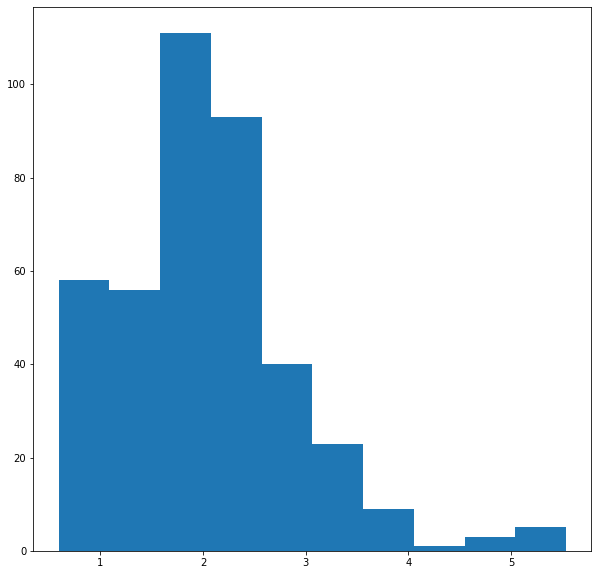

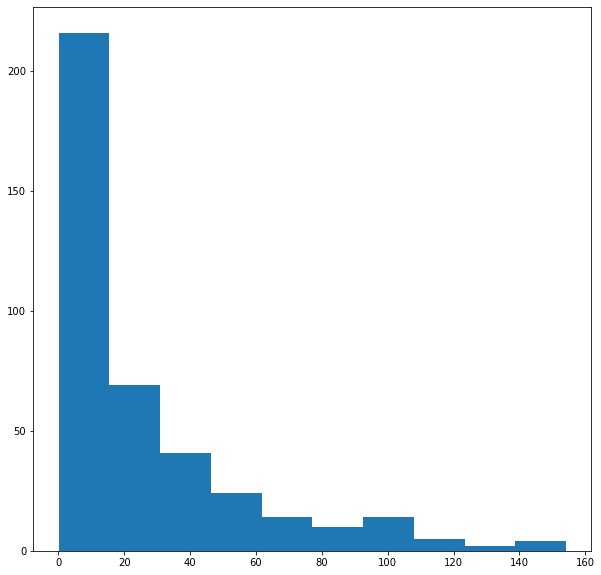

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(D0)
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.hist(rainrate)

In [64]:
print(ND2_list[0])

<xarray.DataArray (D0_RR: 380, diameter_bin: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time           (D0_RR) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    flagged times  (D0_RR) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    D0             (D0_RR) float64 nan nan nan nan nan ... nan nan nan nan nan
    RR             (D0_RR) float64 nan nan nan nan nan ... nan nan nan nan nan
  * D0_RR          (D0_RR) MultiIndex
  - D0_idx         (D0_RR) int64 140 140 140 140 140 140 ... 140 1

In [65]:
ND2_list_2 = []

for ND2 in ND2_list:
#     print(D0_indices)
#     print([D0_bins[x[0]] for x,_ in list(ND2.groupby('D0_RR'))])
#     print([RR_bins[x[1]] for x,_ in list(ND2.groupby('D0_RR'))])
#     print([y.sizes['time'] for x,y in list(ND2.groupby('D0_RR'))])
    #ND2 = ND2.reset_index('time')
    ND2_list_2.append(ND2)
    
ND2_combined = xr.concat(ND2_list_2, dim='D0_RR')
ND2_groups = ND2_combined.groupby('D0_RR')
print(list(ND2.groupby('D0_RR')))

[((11, 0), <xarray.DataArray (D0_RR: 1, diameter_bin: 32)>
array([[         nan,          nan,          nan, 135.94402505,
        350.69343166, 133.47141554,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan]])
Coordinates:
    time           (D0_RR) datetime64[ns] 2016-03-31T22:58:33
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    flagged times  (D0_RR) int64 0
    D0             (D0_RR) float64 0.5945
    RR             (D0_RR) float64 0.07493
 

0.05
0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.45 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.55 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001 0.11000000000000001
0.6000000000000001

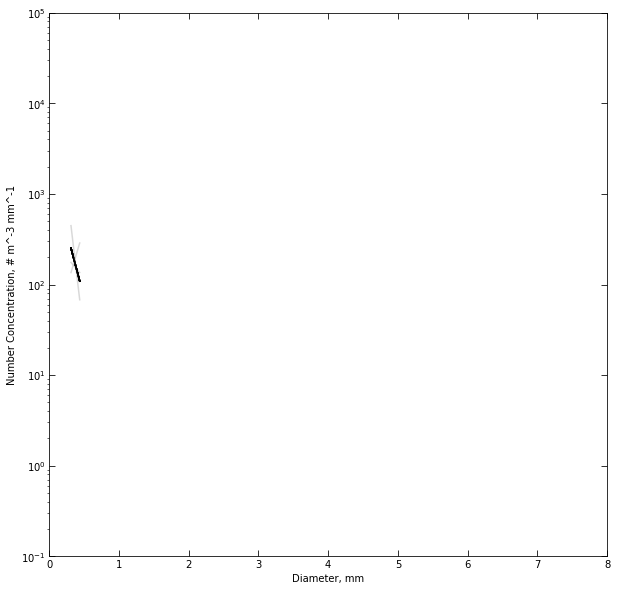

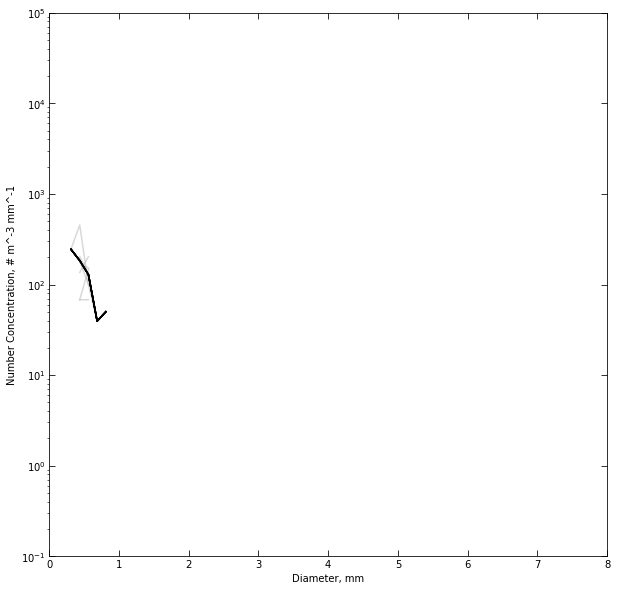

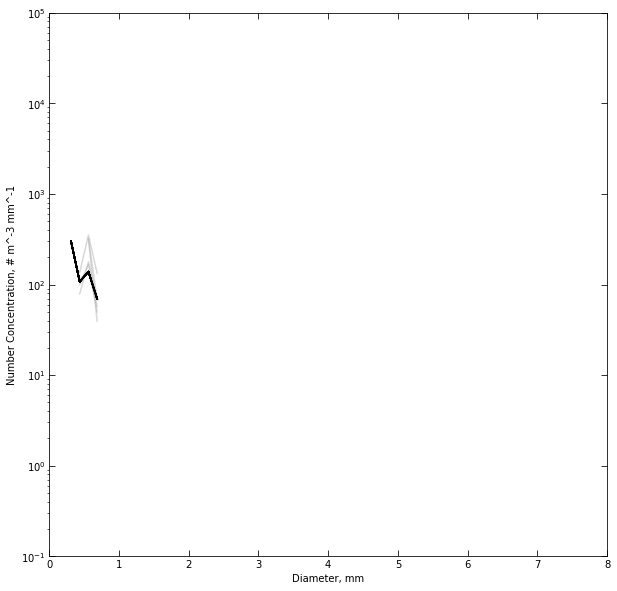

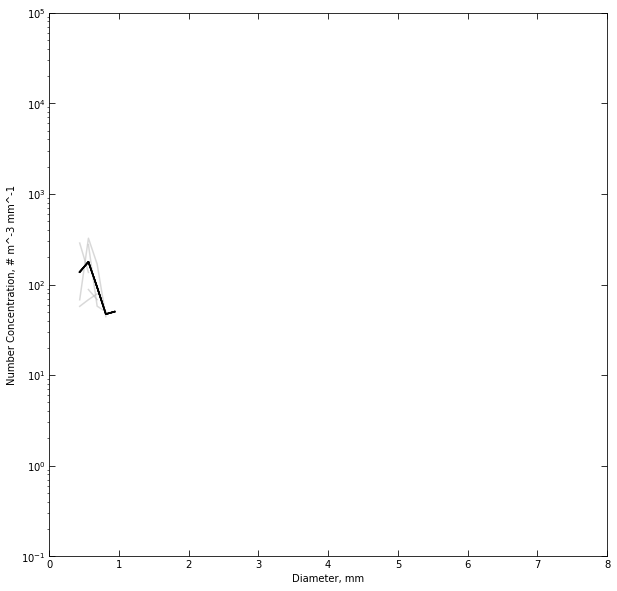

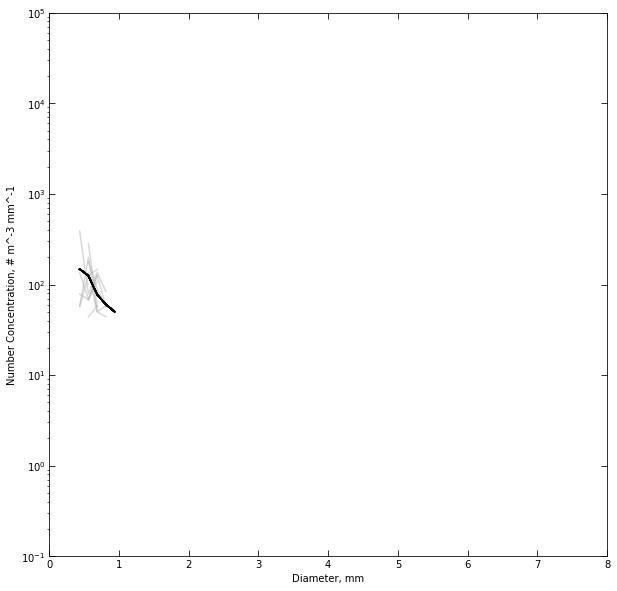

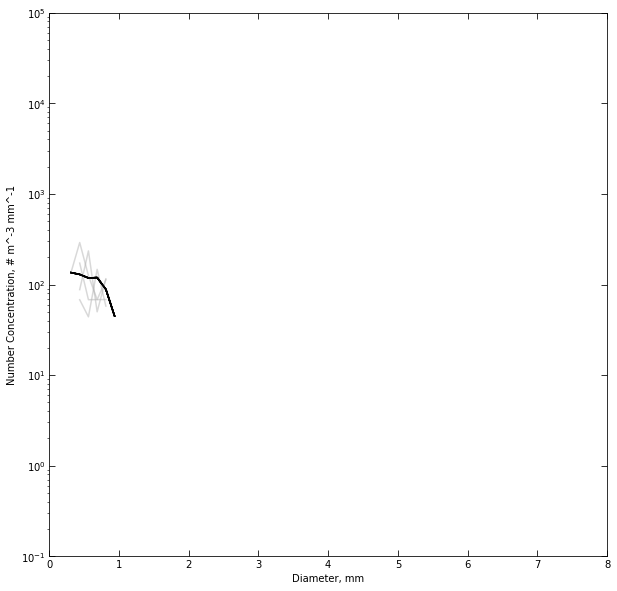

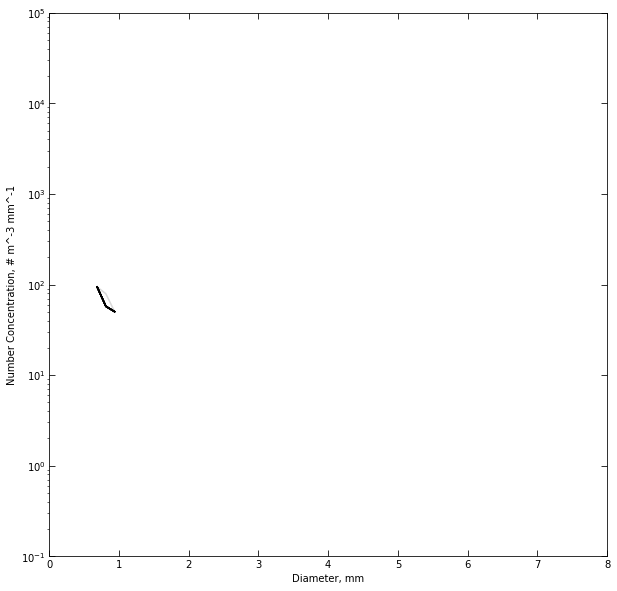

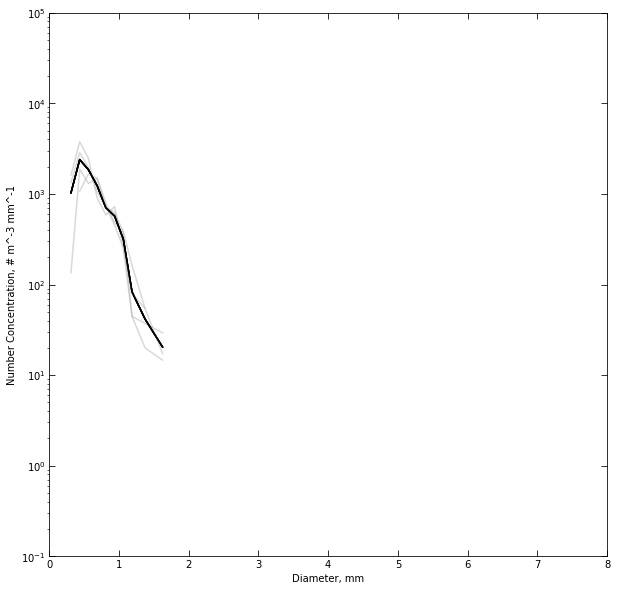

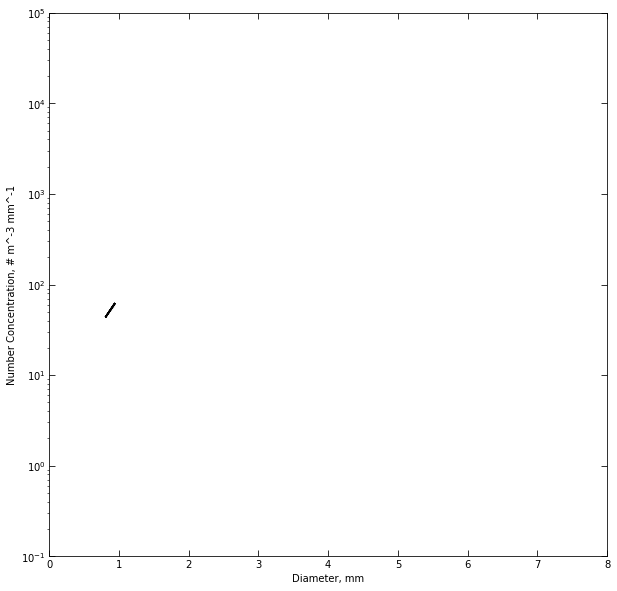

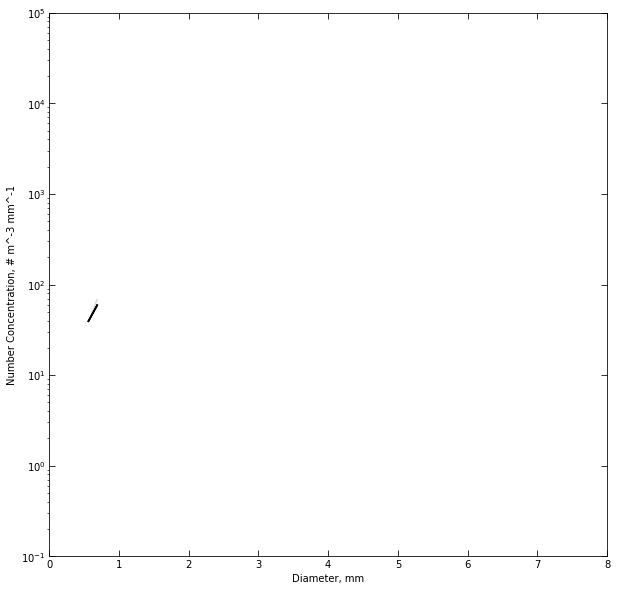

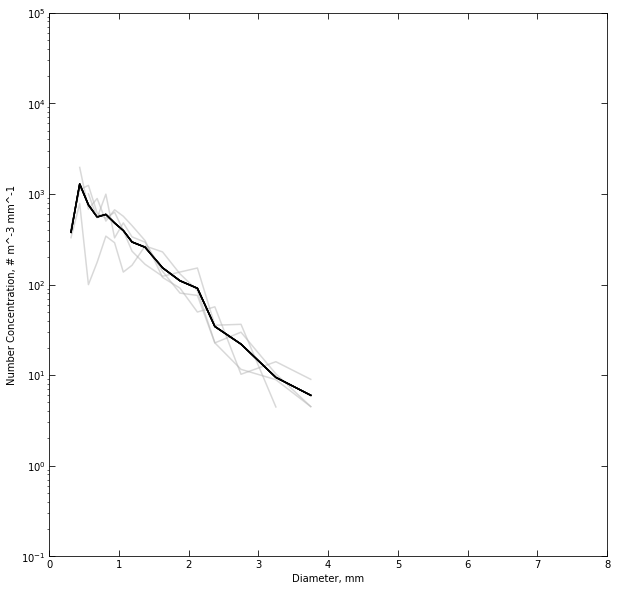

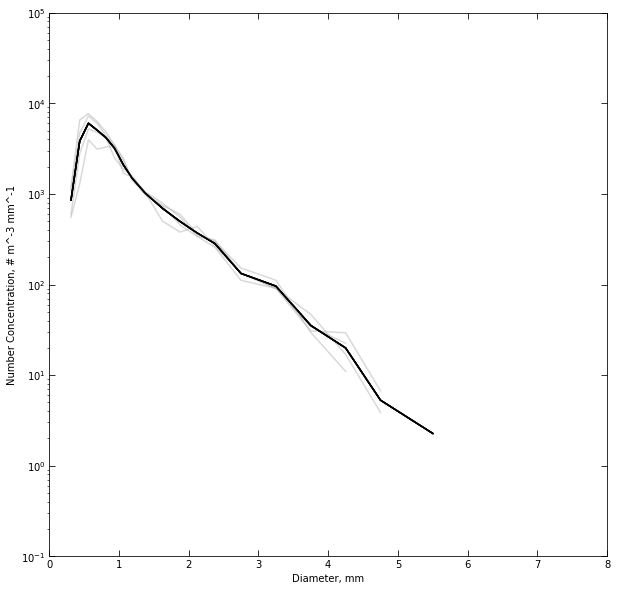

In [69]:
print(D0_bins[0])
print(RR_bins[0])
for group, ND2_group in list(ND2_groups)[:-1]:
    num_DSDs = ND2_group.sizes['D0_RR']
    #print(group, num_DSDs)
    if num_DSDs > 3.:
        fig, ax = plt.subplots(figsize=(10,10))
        ND_group_avg = ND2_group.mean('D0_RR')
        for ND in ND2_group:
            # print(ND)
            print(D0_bins[group[0]], RR_bins[group[1]])
            ax.plot(ND2_group['diameter'], ND, color='0.7', alpha=0.5)
            ax.plot(ND2_group['diameter'], ND_group_avg, 'k')
#             ax.plot(avg_diameter,
#                     Nc_bin_avg[r,
#                                d],
#                     'k',
#                     label='(R,D0) = (%2.2f' % midpoint_R + ',%2.2f' % midpoint_D0 + ')')
            ax.set_yscale('log')
            ax.set_ylim(10.**-1.0, 10.**5.0)
            ax.set_ylabel('Number Concentration, # m^-3 mm^-1')
            ax.set_xlim(0.0, 8.0)
            ax.set_xlabel('Diameter, mm')
            ax.tick_params(direction='in', length=6, top='on', right='on')
#             ax.legend(
#                 bbox_to_anchor=(
#                     1.,
#                     1.),
#                 loc='upper right',
#                 ncol=1,
#                 fancybox=True,
#                 shadow=False)

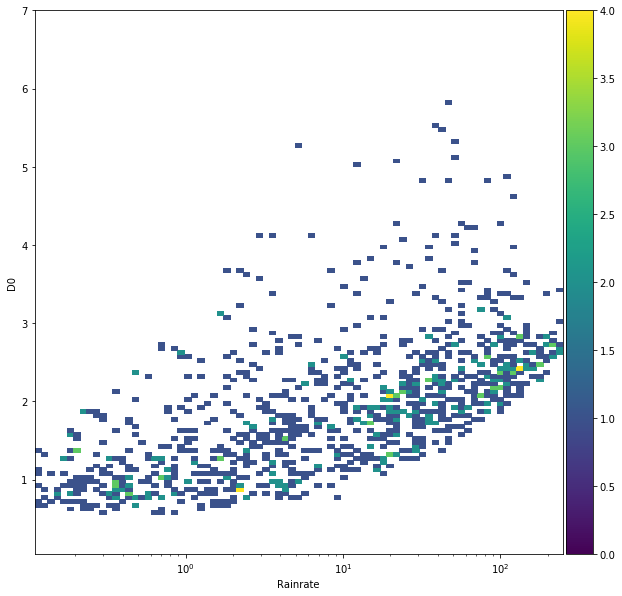

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))

hist, xedges, yedges = np.histogram2d(ND2_combined['RR'], ND2_combined['D0'], bins=(RR_bins, D0_bins))
hist = np.ma.masked_where(hist <= 0.0, hist)
# add 2D color grid of bin sum
ax.set_xscale('log')
C = ax.pcolormesh(RR_bins, D0_bins, hist.T, vmin=0.0, vmax=4.0)
ax.set_xlabel('Rainrate')
ax.set_ylabel('D0')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(C, orientation='vertical', cax=cax)

In [71]:
print(ND2_combined)
ND_avg = ND2_groups.mean(dim='D0_RR')
print(ND_avg)

<xarray.DataArray (D0_RR: 1774, diameter_bin: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    time           (D0_RR) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:33:53
    flagged times  (D0_RR) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    D0             (D0_RR) float64 nan nan nan nan ... 1.259 2.281 1.516 1.412
    RR             (D0_RR) float64 nan nan nan nan ... 1.715 4.36 2.017 1.658
  * D0_RR          (D0_RR) MultiIndex
  - D0_idx         (D0_RR) int64 140 140 140 140 140 140 ... 27 32

In [84]:
print(ND2_combined)
ND2_combined_2 = ND2_combined.reset_index('D0_RR')
print(ND2_combined_2)
print(ND2_combined_2['D0_idx'].dims[0])
D0_idx = ND2_combined_2['D0_idx'].values
RR_idx = ND2_combined_2['RR_idx'].values
ND2_combined_2 = ND2_combined_2.reset_coords(names=['D0_idx', 'RR_idx'], drop=True)
ND2_combined_2.coords['D0_RR'] = ('D0_RR', 
                                  pd.MultiIndex.from_arrays([D0_idx, RR_idx], names=['D0_idx', 'RR_idx']))
# ND2_combined_2 = ND2_combined_2.rename({'D0_RR_level_0': 'D0_idx', 'D0_RR_level_1': 'RR_idx'})

print(ND2_combined_2)

<xarray.DataArray (D0_RR: 1774, diameter_bin: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    time           (D0_RR) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:33:53
    flagged times  (D0_RR) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    D0             (D0_RR) float64 nan nan nan nan ... 1.259 2.281 1.516 1.412
    RR             (D0_RR) float64 nan nan nan nan ... 1.715 4.36 2.017 1.658
  * D0_RR          (D0_RR) MultiIndex
  - D0_idx         (D0_RR) int64 140 140 140 140 140 140 ... 27 32

In [72]:
# Testing unstacking of averaged ND dataarray

ND_avg_unstacked = ND_avg.unstack(dim='D0_RR')
print(ND_avg_unstacked)
# Rename the new dimensions back to what they were before because for some reason doing averages on a groupby object
# resets the names of the multiindex levels
ND_avg_unstacked = ND_avg_unstacked.rename({'D0_RR_level_0': 'D0_idx', 'D0_RR_level_1': 'RR_idx'})
ND_avg_unstacked = ND_avg_unstacked.reindex({'D0_idx': range(D0_bins.size), 'RR_idx': range(RR_bins.size)})
ND_avg_unstacked.coords['D0'] = ('D0_idx', D0_bins)
ND_avg_unstacked.coords['RR'] = ('RR_idx', RR_bins)
print(ND_avg_unstacked)

<xarray.DataArray (diameter_bin: 32, D0_RR_level_0: 90, D0_RR_level_1: 83)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,         

In [73]:
ND_avg_unstacked.name = 'SATP_ND'


In [ ]:
# OLD CELLS BELOW

In [ ]:
# Compute sigma and Dm
D = ND_list[0]['diameter']
dD = ND_list[0]['max_diameter'] - ND_list[0]['min_diameter']

Dm_list = []
sigma_list = []

for ND in ND_list:
    Dm = dsd.calc_Dmpq_binned(4, 3, ND)
    sigma = dsd.calc_sigma(D, dD, ND)
    
    Dm_list.append(Dm)
    sigma_list.append(sigma)

In [ ]:
# Plot sigma vs Dm
fig, ax = plt.subplots(figsize=(10, 10))
sc_list = []

for Dm, sigma in zip(Dm_list, sigma_list):
    sc = ax.scatter(Dm * 1000., sigma * 1000.)
    sc_list.append(sc)
ax.set_xlim(0.0, 6.0)
ax.set_ylim(0.0, 3.5)

In [ ]:
DSD_fit = xr.open_dataset('/Users/dawson29/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/DSD_fits_PIPS2B_60s_20160331220000_20160331234000.nc')

In [ ]:
conv_df = pips.calc_thermo(conv_df)

DSD_interval = 10.
PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)
PSDstarttimes = PSD_datetimes_dict['PSD_datetimes_edges']
PSDmidtimes = PSD_datetimes_dict['PSD_datetimes']

sec_offset = PSD_datetimes[0].second
conv_resampled_df = pips.resample_conv('PIPS', DSD_interval, sec_offset, conv_df)
conv_resampled_df_index = conv_resampled_df.index.intersection(parsivel_df.index)
conv_resampled_df = conv_resampled_df.loc[conv_resampled_df_index]

print(parsivel_df.columns)
#print(conv_resampled_df)

#parsivel_resampled_df = pips.resample_parsivel(60., parsivel_df)
resample_interval = 60.
intervalstr = '{:d}S'.format(int(resample_interval))
parsivel_resampler = parsivel_df.resample(intervalstr, label='right', closed='right',
                                          base=sec_offset)

parsivel_resampled_df = parsivel_resampler.agg({'precipintensity': np.mean, 'precipaccum': np.sum,
                                   'parsivel_dBZ': np.mean, 'pcount': np.sum,
                                   'signal_amplitude': np.mean, 'pvoltage': np.mean, 'sensor_temp': np.mean,
                                   'sample_interval': np.mean})

print(parsivel_resampled_df.columns)


# for time in vd_matrix_da['time'].to_index():
#     print(parsivel_df['pcount'].loc[time])
#     # print(conv_resampled_df['rho'].loc[time])
#     # print(vd_matrix_da.loc[time])

In [ ]:
# Do some QC
vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
vdQC = vd_matrix_QC.loc['2016-03-31T22:30:03']
vdQC['diameter'] = ('diameter_bin', diameter_bins)
vdQC['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vdQC.where(vdQC > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])
plt.plot(diameter_bins, empirical_fallspeed, color='r')

In [ ]:
# Calculate ND
ND = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum, 10.)

In [ ]:
timelimits = [PSDstarttimes[0], PSDstarttimes[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = dates.MinuteLocator(byminute=range(0, 60, 5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

disvars = {
    'min_diameter': ND['min_diameter'], 
    'PSDstarttimes': PSDstarttimes,
    'PSDmidtimes': PSDmidtimes, 
    'logND': np.log10(ND).T
}
dis_plot_name = 'PIPS1A'
PIPSplot.plotDSDmeteograms(dis_plot_name, './', axparams, disvars)

In [ ]:
np.log10(ND).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)

In [ ]:
# Now resample the vd matrix across time to go from 10-s to 60-s intervals
resample_interval = pips.check_requested_resampling_interval(60., 10.)
vd_matrix_rs = pips.resample_vd_matrix(resample_interval, vd_matrix_QC)
print(vd_matrix_QC['time'][:10])
print(vd_matrix_rs['time'][:10])

In [ ]:
ND_resampled = pips.calc_ND(vd_matrix_rs.where(vd_matrix_rs > 0.0), fallspeed_spectrum, 60.)
np.log10(ND_resampled).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)



In [ ]:
# Add additional thermodynamic variables to conv_df
conv_df = pips.calc_thermo(conv_df)

In [ ]:
# Resample conventional data to 60-s
datetime_range_onesec = conv_df.index.to_pydatetime()
sec_offset = pips.get_offset_seconds(datetime_range_onesec)
conv_rs_df = pips.resample_conv('PIPS', 60., sec_offset, conv_df)

In [ ]:
print(ND_resampled)

In [ ]:
# Compute sigma and Dm
Dm = dsd.calc_Dmpq_binned(4, 3, ND_resampled)
D = ND_resampled['diameter']
dD = ND_resampled['max_diameter'] - ND_resampled['min_diameter']

# D_m = D / 1000.
# dD_m = dD / 1000.
# Dm_m = Dm

# # print(D_m * 1000.)
# # print(dD_m * 1000.)
# # print(Dm_m * 1000.)

# ND_mneg4 = ND_resampled * 1000.

# sigma_numerator_bin = (D_m - Dm_m)**2. * ND_mneg4 * D_m**3. * dD_m
# #print(sigma_numerator_bin)
# sigma_numerator = sigma_numerator_bin.sum(dim='diameter_bin') # np.sum(sigma_numerator_bin, axis=0)
# #print(sigma_numerator)

# M3, _ = dsd.calc_moment_bin(ND_resampled, moment=3)
# #print(M3)


# sigma = np.sqrt(sigma_numerator / M3)
# print(sigma)

sigma = dsd.calc_sigma(D, dD, ND_resampled)

In [ ]:
# Plot sigma vs Dm
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(Dm * 1000., sigma * 1000.)
# ax.set_xlim(0.0, 3.5)
# ax.set_ylim(0.0, 2.0)

In [ ]:
M2, _ = dsd.calc_moment_bin(ND_resampled, moment=2)
M3, _ = dsd.calc_moment_bin(ND_resampled, moment=3)
M4, _ = dsd.calc_moment_bin(ND_resampled, moment=4)
M6, _ = dsd.calc_moment_bin(ND_resampled, moment=6)

DSD_MM24 = dsd.fit_DSD_MM24(M2, M4)
DSD_MM36 = dsd.fit_DSD_MM36(M3, M6)
DSD_MM346 = dsd.fit_DSD_MM346(M3, M4, M6)
DSD_MM246 = dsd.fit_DSD_MM246(M2, M4, M6)
DSD_MM234 = dsd.fit_DSD_MM234(M2, M3, M4)

D_min, D_max = dsd.get_max_min_diameters(ND_resampled)
print(D_max)

DSD_TMM246 = dsd.fit_DSD_TMM_xr(M2, M4, M6, D_min, D_max)

In [ ]:
ND_MM24 = dsd.calc_binned_DSD_from_params(*DSD_MM24, ND_resampled['diameter'])
ND_MM36 = dsd.calc_binned_DSD_from_params(*DSD_MM36, ND_resampled['diameter'])
ND_MM234 = dsd.calc_binned_DSD_from_params(*DSD_MM234, ND_resampled['diameter'])
ND_MM246 = dsd.calc_binned_DSD_from_params(*DSD_MM246, ND_resampled['diameter'])
ND_MM346 = dsd.calc_binned_DSD_from_params(*DSD_MM346, ND_resampled['diameter'])
ND_TMM246 = dsd.calc_binned_DSD_from_params(*DSD_TMM246, ND_resampled['diameter'])

In [ ]:
# Test plotting of individual DSD
time_to_plot = '2016-03-31T22:31:53'

axdict = {
    'xbin_left': ND_resampled['min_diameter'],
    'xbin_mid': ND_resampled['diameter'], 
    'xbin_right': ND_resampled['max_diameter'],
    'xlim': (0.0, 9.0), 
    'ylim': (10.**2., 10.**8.5), 
    'interval': int(resample_interval),
    'dis_name': 'PIPS_1A'
}

#print(ND_resampled['time'])

PSDdict = {
    'ND': ND_resampled.loc[time_to_plot]
}

PSDfitdict = {
    #'Exponential_24': (ND_MM24.loc[time_to_plot], 'Exp fit (MM24)'),
    #'Exponential_36': (ND_MM36.loc[time_to_plot], 'Exp fit (MM36)'),
    #'Gamma_234': (ND_MM234.loc[time_to_plot], 'Gamma fit (MM234)'),
    'Gamma_246': (ND_MM246.loc[time_to_plot], 'Gamma fit (MM246)'),
    #'Gamma_346': (ND_MM346.loc[time_to_plot], 'Gamma fit (MM346)')
    'TruncGamma_246': (ND_TMM246.loc[time_to_plot], 'Truncated Gamma fit (TMM246)'),
}

time_to_plot_datetime = pd.to_datetime(time_to_plot).to_pydatetime()

print(DSD_TMM246[0].loc[time_to_plot])

In [ ]:
import pyPIPS.timemodule as tm
xbin_left = axdict.get('xbin_left', np.empty((0)))
xbin_right = axdict.get('xbin_right', np.empty((0)))
xbin_mid = axdict.get('xbin_mid', np.empty((0)))
ND = PSDdict.get('ND', np.empty((0)))
# ND_onedrop = PSDdict.get('ND_onedrop', N.empty((0)))
interval = axdict.get('interval', 10)
dis_name = axdict.get('dis_name', None)

fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)
plt.title('{0:d}-s DSD fits for time {1} EST'.format(interval, time_to_plot_datetime.strftime(tm.timefmt2)))
ax1.bar(xbin_left, ND * 1000.0, xbin_right - xbin_left, 10.**2., align='edge', log=True, color='tan', 
        edgecolor='k')

for fitname, ND_tuple in PSDfitdict.items():
    if ((fitname == 'Dis Retr') | (fitname == 'Rad Retr')):
        ND_fit = ND_tuple[0] * 1000.
    else:
        ND_fit = ND_tuple[0]
#         print ND_fit
    label = ND_tuple[1]
    if(ND_fit.size):
        ax1.plot(xbin_mid, ND_fit, lw=2, label=label)

plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=8)
        
ax1.set_yscale('log')
ax1.set_ylim(10.**2.0, 10.**8.5)
ax1.set_xlim(0.0, 9.0)
ax1.set_xlabel('D (mm)')
ax1.set_ylabel(r'N(D) $(m^{-4})$')


In [ ]:
# Test merging of fit DataArrays to a Dataset

#print(DSD_MM24[0])

DSD_MM24[0].name = 'N0'
DSD_MM24[1].name = 'lamda'
# DSD_MM24[2].name = 'alpha'

DSD_MM24_da = xr.concat(DSD_MM24[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM24_da.name = 'DSD_MM24'
#print(DSD_MM24_da)

# DSD_MM24_ds = xr.merge(DSD_MM24[:2])

DSD_MM36[0].name = 'N0'
DSD_MM36[1].name = 'lamda'
DSD_MM36_da = xr.concat(DSD_MM36[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM36_da.name = 'DSD_MM36'
#print(DSD_MM36_da)

# DSD_MM36_ds = xr.merge(DSD_MM36[:2])

# fits_ds = xr.concat([DSD_MM24_da, DSD_MM36_da], dim='fit')

names = ['DSD_MM24', 'DSD_MM36']
data_arrays = [DSD_MM24_da, DSD_MM36_da]

fits_ds = xr.Dataset({name: da for name, da in zip(names, data_arrays)})
print(fits_ds)

# fits_ds = xr.merge([DSD_MM24, DSD_MM36, DSD_MM234, DSD_MM246, DSD_MM346, DSD_TMM246])
# print(fits_ds)


In [ ]:
conv_df, parsivel_df, _ = pipsio.read_PIPS(filepath)
parsivel_ds = parsivel_df.to_xarray()

In [ ]:
DSD_MM246 = fits_ds['DSD_MM']

In [ ]:
# Test converting conventional data DataFrame to xarray

print(conv_df)
conv_ds = conv_df.to_xarray()
conv_ds


In [ ]:
conv_ds = pipsio.conv_df_to_ds(conv_df)
print(conv_ds)
print(conv_ds['GPS_spd'])

In [ ]:
conv_nc_path = './conv_test.nc'
pipsio.dump_conv_netcdf(conv_nc_path, conv_ds)
conv_ds_from_netcdf.close()
conv_ds_from_netcdf = xr.open_dataset(conv_nc_path)
print(conv_ds_from_netcdf)
print(conv_ds_from_netcdf['time'])

In [ ]:
print(conv_ds_from_netcdf['GPS_time'])

In [ ]:
_, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)
parsivel_ds = pipsio.parsivel_df_to_ds(parsivel_df)

In [ ]:
parsivel_ds = pipsio.combine_parsivel_data(parsivel_ds, vd_matrix_da)
parsivel_ds